Ambystoma barbouri state range summary


,FWS_range(y/n),BISON_occurrences,has_BISON_Data(y/n),SGCN_2005(y/n),SGCN_2015(y/n),has_GAP_habitat(y/n)
State,,,,,,
Alabama,1,4,1,0,0,0
Alaska,0,0,0,0,0,0
Arizona,0,1,1,0,0,0
Arkansas,0,36,1,0,0,0
California,0,306,1,0,0,0
Colorado,0,7,1,0,0,0
Connecticut,0,337,1,0,0,0
Delaware,0,0,0,0,0,0
District of Columbia,0,0,0,0,0,0


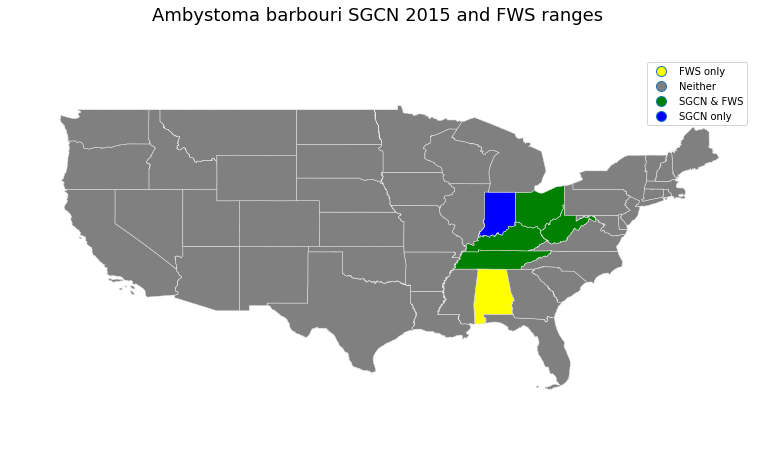

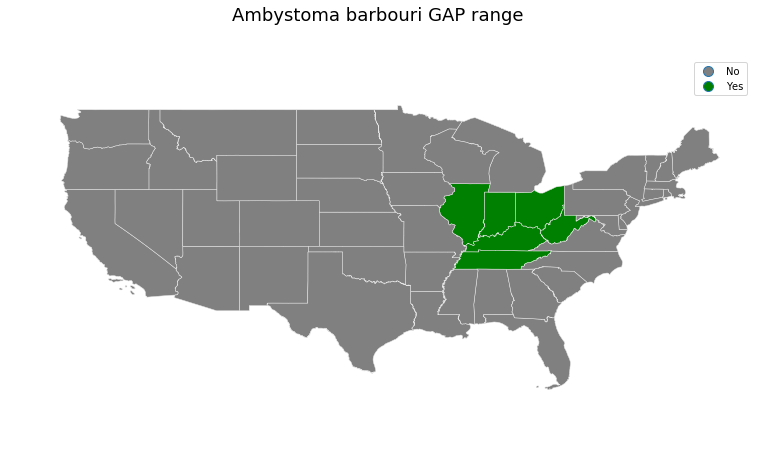

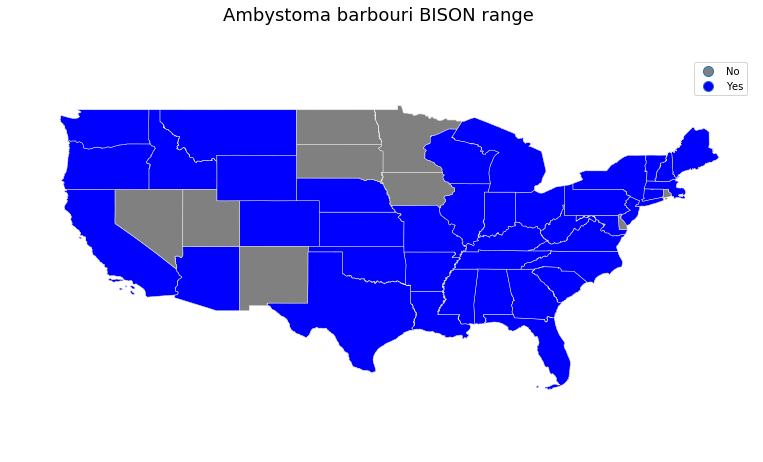

In [26]:
%matplotlib inline  


# -*- coding: utf-8 -*-
"""
nmtarr 9/7/2018

Description: Script used in developing State range summaries.ipynb.

"""
#from IPython.display import display as display1
from matplotlib.colors import ListedColormap    
import us
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', 100)
# Widens the display in a notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# import config file with username and password
import sys
sys.path.append("T:/BCB/")
import BISdbConfig as config

# pybis needs environment variables to connect to the database.
import os
os.environ['DB_USERNAME']=config.user
os.environ['DB_PASSWORD']=config.password
os.environ['MONGODB_SERVER']="54.91.95.139"
os.environ['DB_DATABASE']="bis"

# Connect to bis and get collection
from pybis import db
bisDB = db.Db.connect_mongodb("bis")
esaWPSpecies = bisDB["FWS_Work_Plan_Species"]


## Get a list of species names to loop on.
spp = [record["Submitted Data"]["Scientific Name"] for record in esaWPSpecies.find()]

for sp in spp[:1]:
    # Build dataframe to fill out
    columns=[]
    df0 = pd.DataFrame(index=[str(x) for x in us.STATES], columns=columns)
    df0.index.name="State"
    df0.name=sp
    
    ##########################################################################  FWS
    # Fill out ECOS column with whether or not the ECOS account lists the state
    try:
        Synth = esaWPSpecies.find_one({"Submitted Data.Scientific Name": sp})['Synthesis']
        FWS_states = Synth['FWS Range List']
        for x in FWS_states:
            state_name = x.strip()
            df0.loc[state_name, 'FWS_range(y/n)'] = 1
    except:
        print("Exception -- FWS range")
        
    ########################################################################  BISON
    # How many occurrences are in each state?
    try:
        bison = esaWPSpecies.find_one({"Submitted Data.Scientific Name": sp})['BISON']
        bison_states = bison["US State Occurrences"]
        for state in bison_states:
            state_name = list(state.keys())[0]
            df0.loc[state_name, "BISON_occurrences"]=int(state[state_name])
    except:
        print("No BISON records?")
    
    # Which states have bison occurrences?
    try:
        BISON_states = Synth['States with BISON Occurrence Data']
        for x in BISON_states:
            state_name = x.strip()
            df0.loc[state_name, 'has_BISON_Data(y/n)'] = 1
    except:
        print("Exception -- BISON state list")
    
    #########################################################################  SGCN 
    # Which states declared it SGCN?
    try:
        for x in Synth['SGCN State List 2005']:
            df0.loc[x, 'SGCN_2005(y/n)'] = 1
    
    except:
        print("Exception -- SGCN 2005") 
        
    try:
        for x in Synth['SGCN State List 2015']:
            df0.loc[x, 'SGCN_2015(y/n)'] = 1    
    except:
        print('Exception -- SGCN 2015')
                
    ###################################################################  GAP habitat 
    # Which states have potential habitat (GAP)?
    try:
        GAP_states = Synth['States with GAP Species Potential Habitat']
        for x in GAP_states:
            state_name = x.strip()
            df0.loc[state_name, 'has_GAP_habitat(y/n)'] = 1
    except:
        print('Exception -- GAP states, species.')
    
    #####################################################################  Clean up
    df1 = df0.fillna(0).astype(int)
    # get rid of non-CONUS states
    lowers = [str(x) for x in us.STATES_CONTINENTAL]
    print(sp + ' state range summary')
    df2 = df1.filter(items=lowers, axis=0)
    display(df2)
    print('\n\n') 
    
    ########################################################  Add comparison fields
    # Compare SGCN 2015 to FWS
    codeDict = {(1,1): 'SGCN & FWS', (1,0): 'SGCN only', (0,1): 'FWS only', (0,0): 'Neither'}
    df2['SGCN2015-FWS'] = list(zip(df2['SGCN_2015(y/n)'], df2['FWS_range(y/n)']))
    df2['SGCN2015-FWS'] = [codeDict[x] for x in df2['SGCN2015-FWS']]
    
    
    
    
        # SGCN 2015 vs. FWS
    # Read in state geojson from ScienceBase
    statesGDF = gpd.read_file("T:/Data/state_boundaries.geojson") 
    # Join states geodataframe with species dataframe
    statesGDF2 = pd.merge(df2, statesGDF, how='inner', 
                          left_on=df2.index, right_on=statesGDF.STATE_NAME)
    statesGDF3 = gpd.GeoDataFrame(statesGDF2)
    statesGDF3 = statesGDF3[statesGDF3.STATE_NAME != 'Alaska']
           
    # Plot
    fig, ax = plt.subplots(1, figsize=(13, 7))
    statesGDF3.plot(ax=ax, column="SGCN2015-FWS", legend=True, 
                    cmap=ListedColormap(['yellow', 'grey', 'green', 'blue']),
                    categorical=True, linewidth=0.5, edgecolor='0.9')
    ax.set_ylim(23, 50)
    ax.set_xlim(-126, -66)
    ax.set_axis_off()
    plt.axis('equal')
    fig.suptitle(sp + ' SGCN 2015 and FWS ranges', fontsize=18)
    
    
    # GAP Habitat
    # Convert column values
    statesGDF3['has_GAP_habitat(y/n)'] = [{0: "No", 1: "Yes"}[x] for x in statesGDF3['has_GAP_habitat(y/n)']]
    # Plot
    fig1, ax1 = plt.subplots(1, figsize=(13, 7))
    statesGDF3.plot(ax=ax1, column="has_GAP_habitat(y/n)", legend=True, 
                    cmap=ListedColormap(['grey', 'green']),
                    categorical=True, linewidth=0.5, edgecolor='0.9')
    ax1.set_ylim(23, 50)
    ax1.set_xlim(-126, -66)
    ax1.set_axis_off()
    plt.axis('equal')
    fig1.suptitle(sp + " GAP range", fontsize=18)
    
    
    # BISON
    # Convert column values
    statesGDF3['has_BISON_data(y/n)'] = [{0: "No", 1: "Yes"}[x] for x in statesGDF3['has_BISON_Data(y/n)']]
    # Plot
    fig2, ax2 = plt.subplots(1, figsize=(13, 7))
    statesGDF3.plot(ax=ax2, column="has_BISON_data(y/n)", legend=True, 
                    cmap=ListedColormap(['grey', 'blue']),
                    categorical=True, linewidth=0.5, edgecolor='0.9')
    ax2.set_ylim(23, 50)
    ax2.set_xlim(-126, -66)
    ax2.set_axis_off()
    plt.axis('equal')
    fig2.suptitle(sp + " BISON range", fontsize=18)